# Tutorials Res-IRF fondation

In [1]:
import logging
import os 
import time
import matplotlib.pyplot as plt
os.chdir(os.path.join(os.getcwd(), '..'))

from project.parse_input import *
from project.buildings import HousingStockRenovated, HousingStock
from project.ui_utils import economic_subplots, stock_attributes_subplots

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [2]:
performance_order = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
income_order = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']

In [3]:
def simple_plot(x, y, xlabel, ylabel):
    """Make simple Line2D plot.
    
    Parameters
    ----------
    x: list-like
    y: list-like
    x_label: str
    y_label: str
    """
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_tick_params(which=u'both', length=0)
    ax.yaxis.set_tick_params(which=u'both', length=0)
    plt.show()

In [4]:
folder_output = 'output_tutorial'

## Input

In [5]:
scenario_dict = {
'investor': "Reference",
'cost_intangible': True, 
'lbd_renovation': True,
'info_renovation': True,
'carbon_tax': False,
'carbon_tax_behavior': "myopic",
'cite': False,
'cite_plus': False,
'cee_subsidy': False,
'cee_taxes': False,
'reduced_tax': False,
'eptz': False,
'eptz_plus': False,
'renovation_obligation': False
}

# function of scenario_dict
# TODO: do it manually
label2horizon = dict()
dict_label['label2horizon_heater'] = dict_label['label2horizon_heater'][scenario_dict['investor']]
dict_label['label2horizon_envelope'] = dict_label['label2horizon_envelope'][scenario_dict['investor']]
label2horizon['envelope'] = dict_label['label2horizon_envelope']
label2horizon['heater'] = dict_label['label2horizon_heater']
dict_label['label2horizon'] = label2horizon

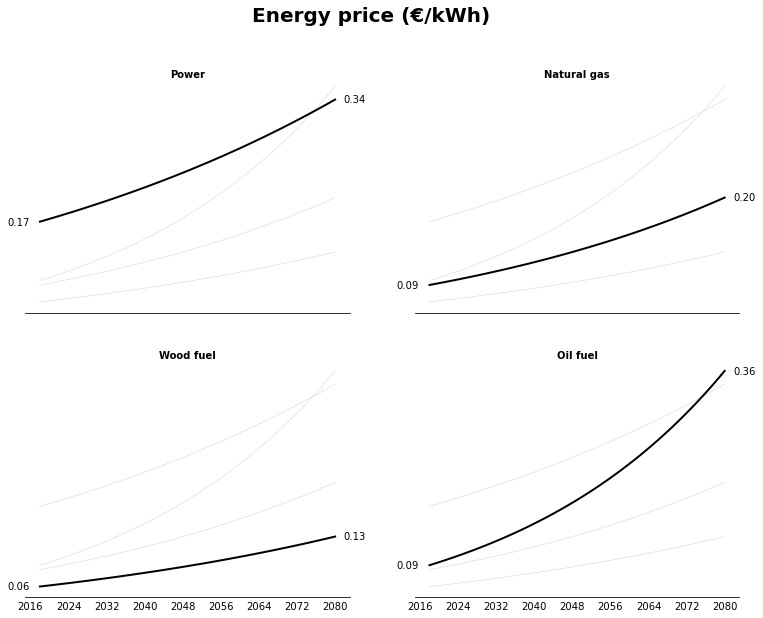

In [6]:
energy_price = energy_prices_dict['energy_price_forecast']
economic_subplots(energy_price, 'Energy price (€/kWh)', n_columns=2, format_val=lambda x: '{:.2f}'.format(x))

Before understanding if objectives are fulfilled or assessing public policies, it is important to observe technologies diffusion.

1. Demolition
2. Renovation


Diffusion of technologies?
- evolution of discrete choices (market share)
- learning-by-doing effect
- renovation rate // number of renovations



# Building stock
TODO: option to show all parameters manually


The model contains 6,720 types of dwellings divided into:
- Nine energy performance levels – EPC labels A to G for existing dwellings, Low Energy Building (LE) and Net Zero Energy Building (NZ) levels for new dwellings;
- Four main heating fuels – electricity, natural gas, fuel oil and fuel wood;
- Six types of investors – owner-occupiers, landlords or social housing managers, each in single- and multi-family dwellings;
- Ten categories of household income, the boundaries of which are aligned with those of INSEE deciles.

## Scope

In [7]:
display(stock_ini_seg.to_frame().head().style.format('{:.1f}'))
print('Total number of buildings: {:.1f}M'.format(stock_ini_seg.sum() / 1000000))
print('Total number of segments (/agents): {:,.0f}'.format(stock_ini_seg.shape[0]))

Total number of buildings: 26.7M
Total number of segments (/agents): 6,720


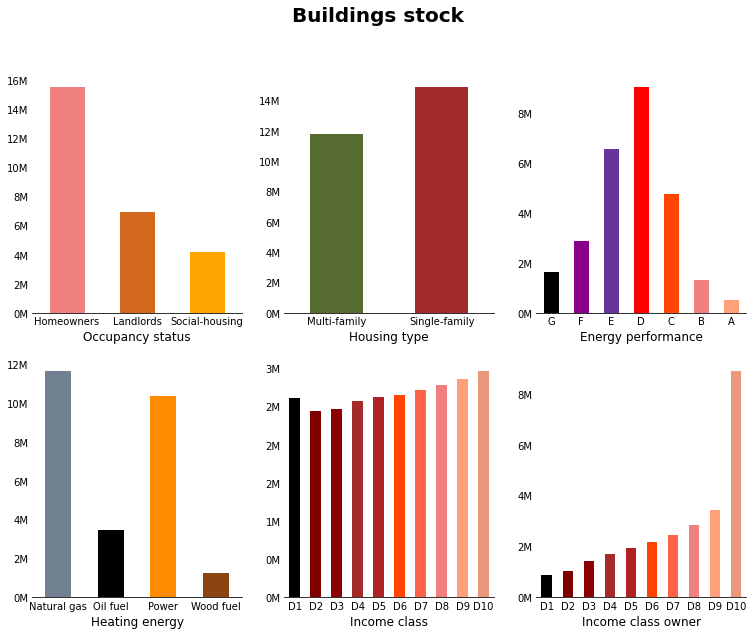

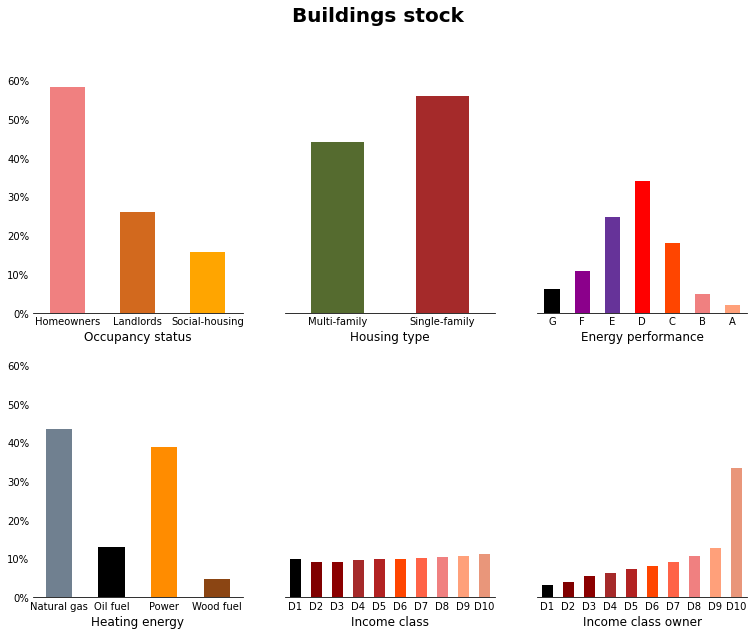

In [8]:
dict_order = {'Income class': income_order, 'Income class owner': income_order, 'Energy performance': performance_order}
stock_attributes_subplots(stock_ini_seg, option='million', dict_color=colors_dict, dict_order=dict_order)
stock_attributes_subplots(stock_ini_seg, option='percent', dict_color=colors_dict, dict_order=dict_order, sharey=True)

# Energy use

The model uses two metrics for energy use: the **conventional consumption** predicted by the EPC label of the dwelling; and the **actual consumption** that determines energy expenditure.  
The two are linked by the *intensity of heating* of the heating infrastructure, which is an endogenous function of the model.

Application:  
**HousingStock** is the main Python class to easly calculate energy use.  

In [9]:
buildings = HousingStock(stock_ini_seg, 
                         levels_dict, 
                         year=2018,
                         price_behavior='myopic',
                         label2area=dict_label['label2area'],
                         label2horizon=dict_label['label2horizon'],
                         label2discount=dict_label['label2discount'],
                         label2income=dict_label['label2income'],
                         label2consumption=dict_label['label2consumption'])

Application:  
Initialize energy use using **ini_energy_cash_flows** method of class HousingStock

In [10]:
help(buildings.ini_energy_cash_flows)

Help on method ini_energy_cash_flows in module project.buildings:

ini_energy_cash_flows(energy_price) method of project.buildings.HousingStock instance
    Initialize exogenous variable that doesn't depend on dynamic to fasten the script.
    
    List of attribute initialized:
    - buildings.area: pd.Series (doesn't depend on time)
    - buildings.budget_share: pd.DataFrame (depends on energy_price and income so depend on time)
    - buildings.use_intensity: pd.DataFrame (depends on energy_price and income so depend on time)
    - buildings.consumption_conventional: pd.Series (doesn't depend on time)
    - buildings.consumption_actual: pd.DataFrame (depends on energy_price and income so depend on time)
    - buildings.energy_cash_flows['conventional']: pd.DataFrame
    - buildings.energy_cash_flows_disc['conventional']: pd.DataFrame
    - buildings.energy_cash_flows['actual']: pd.DataFrame
    - buildings.energy_cash_flows_disc['actual']: pd.DataFrame
    
    Parameters
    -------

In [11]:
buildings.ini_energy_cash_flows(energy_price)

### Heating intensity

A growing number of academic studies point to a gap between the conventional energy consumption predicted
by energy performance certificates and actual energy consumption.
The most common explanation is a more intense heating of the heating infrastructure after an energy efficiency
improvement – a phenomenon commonly referred to as the “rebound effect.”

Heating Intensity = -0.191 * log(Income Share) + 0.1105

In [12]:
display(buildings.use_intensity.head().style.format("{:.1%}", na_rep="-"))

Here we calculated the average heating intensity weighted by dwellings.

In [13]:
use_intensity_average = (buildings.use_intensity.loc[:, 2018] * stock_ini_seg).sum() / stock_ini_seg.sum()
print('Energy use intensity average: {:.2f}%'.format(use_intensity_average * 100))

Energy use intensity average: 78.36%


#### Heating intensity a function of Budget share 

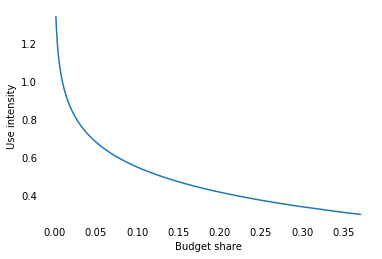

In [14]:
relation = pd.concat((buildings.budget_share.loc[:, 2018], buildings.use_intensity.loc[:, 2018]), axis=1)
relation.columns = ['Budget share', 'Use intensity']
relation.sort_values('Budget share', inplace=True)

simple_plot(relation['Budget share'], relation['Use intensity'], 'Budget share', 'Use intensity')

### Actual energy sue

#### kWh/m2.yr

In [15]:
display(buildings.consumption_actual.head().style.format('{:.1f}'))
consumption_unit_average = (buildings.consumption_actual.loc[:, 2018] * stock_ini_seg).sum() / stock_ini_seg.sum()
print('Consumption average: {:.0f} kWh/m2.yr'.format(consumption_unit_average))

Consumption average: 98 kWh/m2.yr


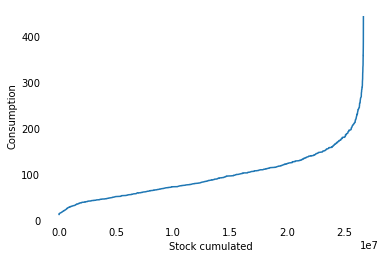

In [16]:
relation = pd.concat((stock_ini_seg, buildings.consumption_actual.loc[:, 2018]), axis=1)
relation.columns = ['Stock', 'Consumption']
relation.sort_values('Consumption', inplace=True)
relation['Stock cumulated'] = relation['Stock'].cumsum()

simple_plot(relation['Stock cumulated'], relation['Consumption'], 'Stock cumulated', 'Consumption')

#### kWh/yr

In [17]:
consumption = (buildings.consumption_actual.T * buildings.area).T
display(consumption.head())
consumption_average = (consumption.loc[:, 2018] * stock_ini_seg).sum() / stock_ini_seg.sum()
print('Consumption average: {:.0f} kWh/yr'.format(consumption_average))

2018  \
Occupancy status Housing type Energy performance Heating energy Income class Income class owner                
Homeowners       Multi-family A                  Natural gas    D1           D1                  2776.126093   
                                                                D10          D10                 3964.812345   
                                                                D2           D2                  3025.915737   
                                                                D3           D3                  3131.921375   
                                                                D4           D4                  3209.645641   

                                                                                                        2019  \
Occupancy status Housing type Energy performance Heating energy Income class Income class owner                
Homeowners       Multi-family A                  Natural gas    D1           D1                  2774.779999   
                                                                D10          D10                 3963.466251   
                                                                D2           D2                  3024.569643   
                                                                D3           D3                  3130.575281   
                                                                D4           D4                  3208.299547   

                                                                                                        2020  \
Occupancy status Housing type Energy performance Heating energy Income class Income class owner                
Homeowners       Multi-family A                  Natural gas    D1           D1                  2773.433905   
                                                                D10          D10                 3962.120157   
                                                                D2           D2                  3023.223550   
                                                                D3           D3                  3129.229187   
                                                                D4           D4                  3206.953453   

                                                                                                        2021  \
Occupancy status Housing type Energy performance Heating energy Income class Income class owner                
Homeowners       Multi-family A                  Natural gas    D1           D1                  2772.087811   
                                                                D10          D10                 3960.774063   
                                                                D2           D2                  3021.877456   
                                                                D3           D3                  3127.883093   
                                                                D4           D4                  3205.607359   

                                                                                                        2022  \
Occupancy status Housing type Energy performance Heating energy Income class Income class owner                
Homeowners       Multi-family A                  Natural gas    D1           D1                  2770.741717   
                                                                D10          D10                 3959.427969   
                                                                D2           D2                  3020.531362   
                                                                D3           D3                  3126.536999   
                                                                D4           D4                  3204.261265   

                                                                                                        2023  \
Occupancy status Housing type Energy performance Heating energy Inc

Consumption average: 8474 kWh/yr


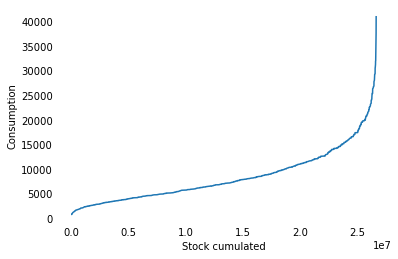

In [18]:
relation = pd.concat((stock_ini_seg, consumption.loc[:, 2018]), axis=1)
relation.columns = ['Stock', 'Consumption']
relation.sort_values('Consumption', inplace=True)
relation['Stock cumulated'] = relation['Stock'].cumsum()

simple_plot(relation['Stock cumulated'], relation['Consumption'], 'Stock cumulated', 'Consumption')

# Transition economics

The energy performance of the housing stock in Res-IRF is affected by both the construction of new dwellings and the renovation of existing ones. Both effects are modelled by discrete choice functions. Generally speaking, the owner of a dwelling of initial performance i∈{1…n} chooses to upgrade it to an option of final performance f∈{i+1,…,n} by comparing its life-cycle cost to that of other options. 
The life-cycle cost $LCC_{(i,f)}$ of an option is the sum of three terms:  
$$LCC_{(i,f)}=INV_{(i,f)}+ γ * ENER_f+ IC_{(i,f)}$$  

where:  
- INV is the investment cost;   
- ENER is the life-cycle discounted cost of conventional energy use, calculated using the energy price for the year under consideration;  
- IC are some “intangible costs,” representing non-energy attributes of the investment, such as aesthetic or acoustic benefits, inconvenience generated by insulation works, etc..

The assumption of myopic expectation, which materializes by applying the discount factor to the contemporaneous energy price, is justified by a number of econometric studies. The discount factor γ depends on the discount rate r and the investment horizon l according to the following relationship:  
$$γ(r,l)=∑_{(t=0)}(1+r)^{-t} =\frac{(1-(1+r)^{-l})}{r}$$


The two parameters are set in Res-IRF so as to capture various barriers to home renovation:
- The discount rate captures both the tighter credit constraints facing lower-income households and the barriers to decision-making within homeowner associations.
- The investment horizon reflects the intensity with which real estate and rental markets capitalize the “green value” of the housing, i.e., magnitude of the rental or resale premium for a property that has just undergone energy efficiency improvements.


The market share $MS_{i,f}$ of upgrades from labels i to f, resulting from the aggregation of individual choices, is determined by their life-cycle cost from the following equation:
$$MS_{i,f}=\frac{LCC_{i,f}^{-v}}{∑_{k=i+1}LCC_{i,k}^{-v}}$$


- Parameter v characterizing the heterogeneity of preferences is set to 8 in the model. 
- Intangible costs are calibrated so that the observed market shares are reproduced in the initial year.

The model simultaneously determines (i) the number of renovations and (ii) their performance. 

## Renovation cost

In [19]:
display(cost_invest['Energy performance'].style.format("{:.1f}", na_rep="-"))

Energy performance final,G,F,E,D,C,B,A
Energy performance,,,,,,,
G,-,79.2,142.0,209.2,282.3,365.5,460.7
F,-,-,65.7,135.9,212.2,298.9,398.1
E,-,-,-,73.0,152.2,242.2,345.0
D,-,-,-,-,82.4,175.7,282.3
C,-,-,-,-,-,97.0,207.4
B,-,-,-,-,-,-,114.7
A,-,-,-,-,-,-,-


The matrix equally applies to single- and multi-family dwellings, in both private and social housing.

In [20]:
display(cost_invest['Heating energy'].style.format("{:.1f}", na_rep="-"))

Heating energy final,Power,Natural gas,Oil fuel,Wood fuel
Heating energy,,,,
Power,0.0,73.0,104.3,125.1
Natural gas,57.3,0.0,83.4,104.3
Oil fuel,57.3,52.1,0.0,104.3
Wood fuel,57.3,52.1,83.4,0.0


## Calculation of life-cycle-cost

### Energy life-cycle cost

In [21]:
help(buildings.to_energy_lcc)

Help on method to_energy_lcc in module project.buildings:

to_energy_lcc(energy_prices, transition=None, consumption='conventional') method of project.buildings.HousingStock instance
    Return segmented energy-life-cycle-cost discounted from segments, and energy prices year=yr.
    
    Energy LCC is calculated on an segment-specific horizon, and using a segment-specific discount rate.
    Because, time horizon depends of type of renovation (label, or heating energy), lcc needs to know which transition.
    NB: transition defined the investment horizon.
    Energy LCC depends on (Occupancy status, Housing type, Income class owner, Energy performance, Heating energy,
    and transition).
    
    Parameters
    ----------
    energy_prices: pd.DataFrame
    transition: list, default ['Energy performance']
    consumption: {'conventional', 'actual}
    
    Returns
    -------
    pd.Series



In [49]:
energy_lcc = buildings.to_energy_lcc(energy_price, transition=['Energy performance'], consumption='conventional')
energy_lcc.name = 'Energy LCC'
display(energy_lcc.head().to_frame().style.format('{:.0f}'))

### Transition life-cycle cost

In [23]:
help(buildings.to_lcc_final)

Help on method to_lcc_final in module project.buildings:

to_lcc_final(energy_prices, cost_invest=None, cost_intangible=None, transition=None, consumption='conventional', policies=None) method of project.buildings.HousingStock instance
    Calculate life-cycle-cost of home-energy retrofits for every segment and every possible transition.
    
    Parameters
    ----------
    energy_prices: pd.DataFrame
        index are heating energy and columns are years.
    cost_invest: dict, optional
        keys are transition (cost_invest['Energy performance']) and item are pd.DataFrame
    cost_intangible: dict, optional
        keys are transition (cost_intangible['Energy performance']) and item are pd.DataFrame
    consumption: {'conventional', 'actual'}, default 'conventional
    transition: {['Energy performance'], ['Heating energy'], ['Energy performance', 'Heating energy']}, default ['Energy performance']
        define transition. Transition can be defined as label transition, energy tr

In [52]:
lcc_final = buildings.to_lcc_final(energy_price, cost_invest=cost_invest, cost_intangible=None,
                                   transition=['Energy performance'], consumption='conventional', policies=None)
display(lcc_final.tail().style.format('{:.0f}', na_rep="-"))

lcc_final.dropna(how='all', axis=0, inplace=True) 
print('Data grouped by Energy performance initial:')
lcc_final.groupby('Energy performance').mean()

Data grouped by Energy performance initial:


Energy performance final,G,F,E,D,C,B,A
Energy performance,,,,,,,
B,NaN,NaN,NaN,NaN,NaN,NaN,128.734990
C,NaN,NaN,NaN,NaN,NaN,115.780906,221.468639
D,NaN,NaN,NaN,NaN,111.304517,194.563845,296.310345
E,NaN,NaN,NaN,118.426355,181.183190,261.043466,359.036412
F,NaN,NaN,135.002242,181.340099,241.135797,317.742992,412.128355
G,NaN,182.584127,211.345370,254.638677,311.202148,384.285172,474.791862


B         AxesSubplot(0.1,0.679412;0.363636x0.220588)
C    AxesSubplot(0.536364,0.679412;0.363636x0.220588)
D         AxesSubplot(0.1,0.414706;0.363636x0.220588)
E    AxesSubplot(0.536364,0.414706;0.363636x0.220588)
F             AxesSubplot(0.1,0.15;0.363636x0.220588)
G        AxesSubplot(0.536364,0.15;0.363636x0.220588)
dtype: object

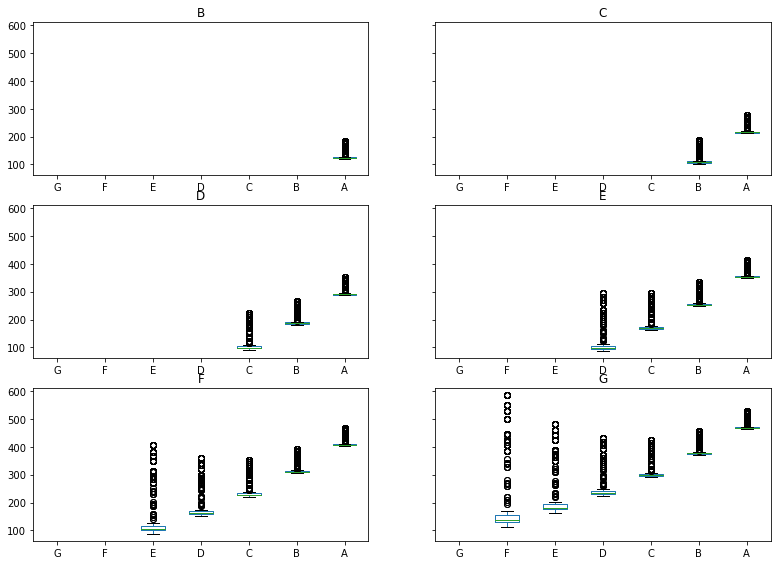

In [27]:
lcc_final.groupby('Energy performance').boxplot(subplots=True, grid=False, figsize=(12.8, 9.6))

## Discrete choice model: Market share

In [28]:
help(buildings.to_market_share)

Help on method to_market_share in module project.buildings:

to_market_share(energy_prices, transition=None, consumption='conventional', cost_invest=None, cost_intangible=None, policies=None, nu=8.0) method of project.buildings.HousingStock instance
    Returns market share for each segment and each possible final state.
    
    Parameter nu characterizing the heterogeneity of preferences is set to 8 in the model.
    Intangible costs are calibrated so that the observed market shares are reproduced in the initial year.
    
    Parameters
    ----------
    energy_prices: pd.DataFrame
    cost_invest: dict, optional
    cost_intangible: dict, optional
    consumption: {'conventional', 'actual'}, default 'conventional
    transition: {['Energy performance'], ['Heating energy'], ['Energy performance', 'Heating energy']},
        default ['Energy performance']
    policies: list, optional
        list of Policies object
    nu: float or int, default 8.0
    
    Returns
    -------
    p

In [54]:
market_share, lcc_final = buildings.to_market_share(energy_price, transition=['Energy performance'], consumption='conventional', cost_invest=cost_invest,
                                                    cost_intangible=None, policies=None, nu=8.0)
display(market_share.tail().style.format('{:.1%}', na_rep="-"))
print('Data grouped by Energy performance initial:')
market_share.groupby('Energy performance').mean().style.format('{:.1%}', na_rep="-")

Data grouped by Energy performance initial:


Energy performance final,G,F,E,D,C,B,A
Energy performance,,,,,,,
A,-,-,-,-,-,-,-
B,-,-,-,-,-,-,100.0%
C,-,-,-,-,-,99.3%,0.7%
D,-,-,-,-,97.8%,2.1%,0.2%
E,-,-,-,93.3%,5.5%,1.1%,0.2%
F,-,-,87.0%,8.0%,3.5%,1.1%,0.2%
G,-,76.8%,12.3%,5.6%,3.5%,1.4%,0.4%


Market share need to be calibrated in order to match observed data.

## Calibration

### Market share observed --> Cost intangible

In [32]:
help(buildings.calibration_market_share)

Help on method calibration_market_share in module project.buildings:

calibration_market_share(energy_prices, market_share_objective, folder_output=None, cost_invest=None, consumption='conventional', policies=None) method of project.buildings.HousingStock instance
    Returns intangible costs by calibrating market_share.
    
    Intangible costs are calibrated so that the observed market shares are reproduced in the initial year.
    Intangible costs are calibrated so that the life-cycle cost model, fed with the investment costs,
    matches the observed market shares.
    
    For each segment:
    LCC final is calculated (depends on Occupancy status, Housing type, Income class owner,
    Energy performance initial, Heating energy initial, transition), then Market Share.
    transition here is Energy performance
    NB: MS doesn't depend on Income class (tenant), so to fasten the function it can be first removed.
    Solver finds Intangible cost for each segment to match the observed

In [55]:
print('Market share observed:')
display(ms_renovation_ini.style.format("{:.0%}", na_rep="-"))

Market share observed:


,G,F,E,D,C,B,A
Energy performance,,,,,,,
G,-,25%,27%,27%,21%,0%,0%
F,-,-,40%,26%,31%,2%,0%
E,-,-,-,66%,28%,6%,0%
D,-,-,-,-,95%,5%,0%
C,-,-,-,-,-,91%,9%
B,-,-,-,-,-,-,100%
A,-,-,-,-,-,-,-


In [34]:
start = time.time()
cost_intangible = buildings.calibration_market_share(energy_price, ms_renovation_ini, 
                                                     cost_invest=cost_invest, 
                                                     consumption='conventional',
                                                     policies=None)
end = time.time()
print('Calibration took {:.0f}s'.format(end - start))

Calibration took 61s


In [56]:
display(cost_intangible.head().style.format('{:.1f}', na_rep="-"))

print('Data grouped by Energy performance initial:')
cost_intangible_mean = cost_intangible.groupby('Energy performance').mean()
display(cost_intangible_mean.loc[['G', 'F', 'E', 'D', 'C'], ['F', 'E', 'D', 'C', 'B', 'A']].style.format('{:,.1f}', na_rep="-"))

print('Cost intangible / Cost investment')
(cost_intangible_mean / cost_invest['Energy performance']).loc[performance_order, performance_order].style.format("{:.0%}", na_rep="-")

AttributeError: 'dict' object has no attribute 'head'

Which attributes impact most intangible cost?

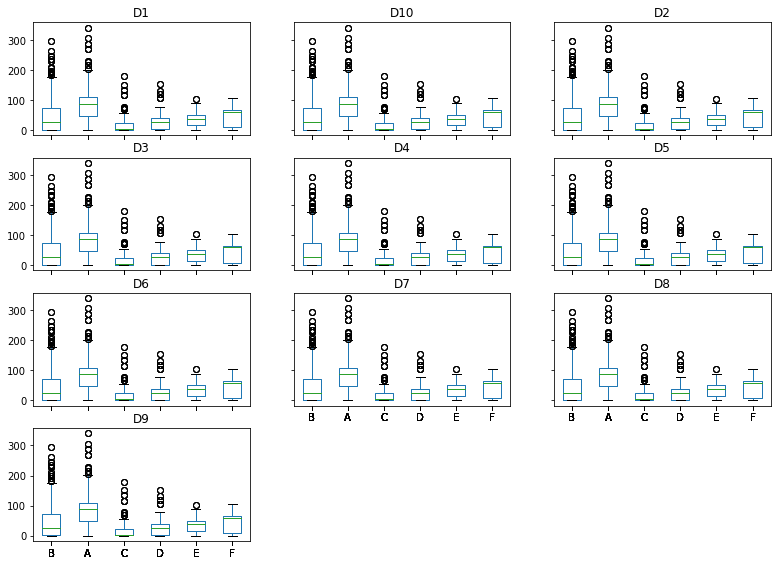

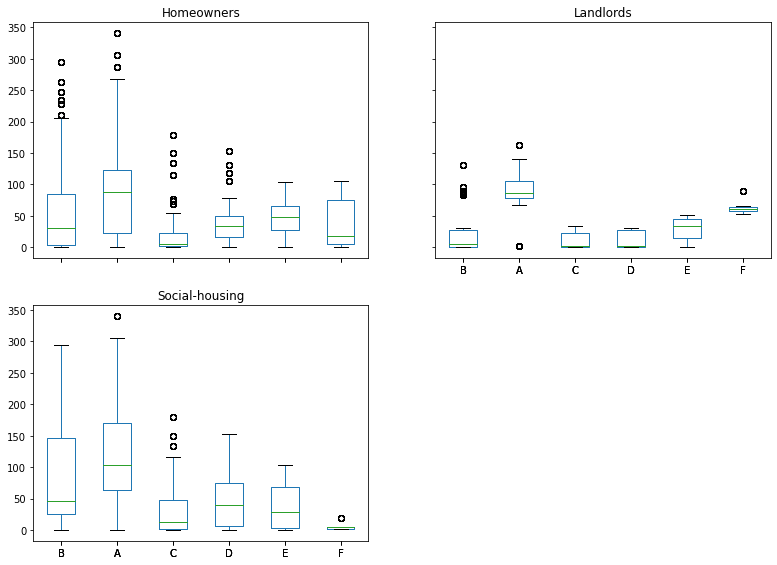

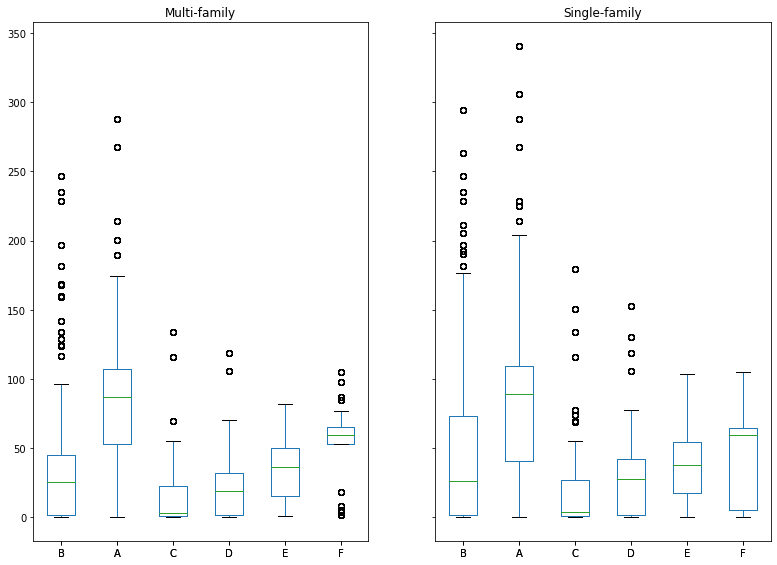

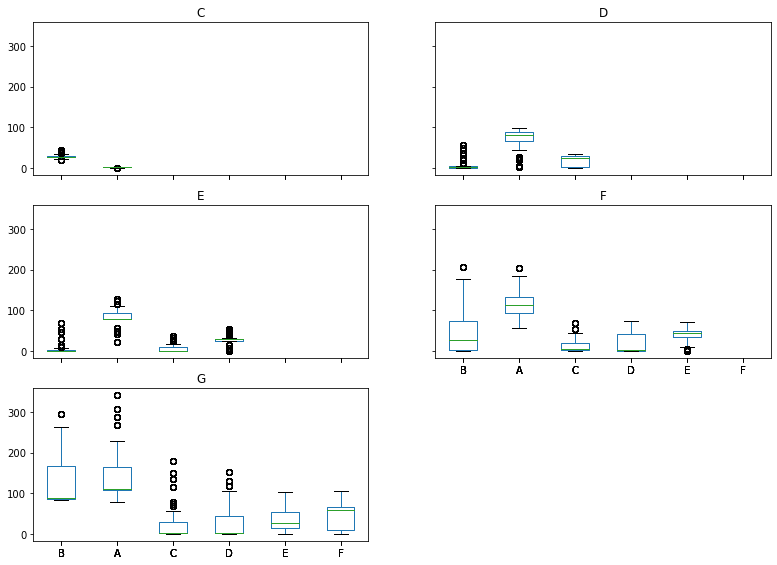

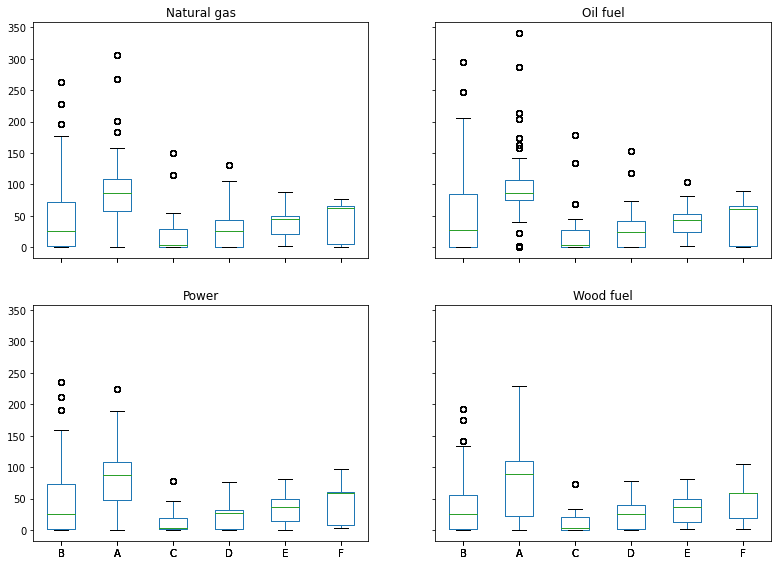

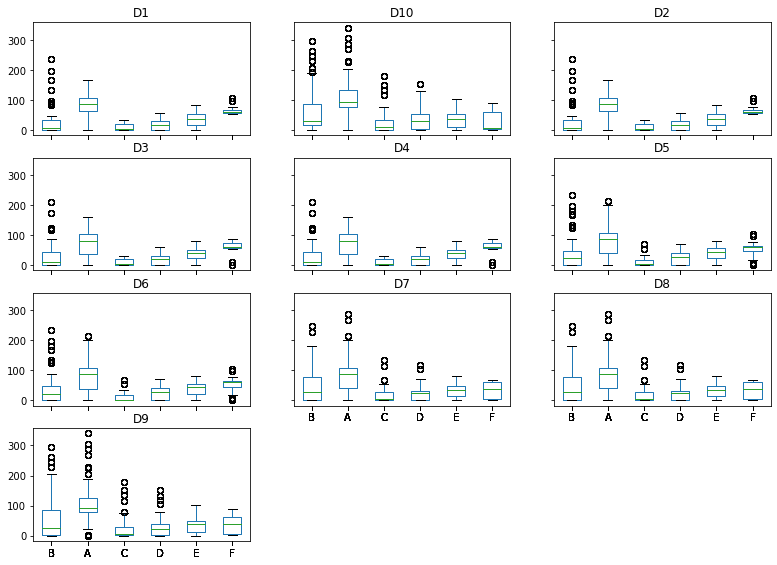

In [38]:
for level in cost_intangible.index.names:
    cost_intangible.groupby(level).boxplot(subplots=True, grid=False, sharex=True, figsize=(12.8, 9.6))

Graphically, Energy performance is where the dispersion is less important.

## Market share and NPV

In [39]:
help(buildings.to_market_share)

Help on method to_market_share in module project.buildings:

to_market_share(energy_prices, transition=None, consumption='conventional', cost_invest=None, cost_intangible=None, policies=None, nu=8.0) method of project.buildings.HousingStock instance
    Returns market share for each segment and each possible final state.
    
    Parameter nu characterizing the heterogeneity of preferences is set to 8 in the model.
    Intangible costs are calibrated so that the observed market shares are reproduced in the initial year.
    
    Parameters
    ----------
    energy_prices: pd.DataFrame
    cost_invest: dict, optional
    cost_intangible: dict, optional
    consumption: {'conventional', 'actual'}, default 'conventional
    transition: {['Energy performance'], ['Heating energy'], ['Energy performance', 'Heating energy']},
        default ['Energy performance']
    policies: list, optional
        list of Policies object
    nu: float or int, default 8.0
    
    Returns
    -------
    p

# Stock dynamics

An upgrade an initial label i  is determined by its net present value (NPV), calculated as the sum of the life-cycle cost of the different options f∈{i+1,…,n}, weighted by their market share:
$$NPV_i=LCC_i - ∑_{f>i} MS_{i,f} * LCC_{i,f}$$
The renovation rate $τ_i$ of dwellings labelled i is then calculated as a logistic function of the NPV:
$$τ_i = \frac{τ_{max}}{(1+(τ_{max}/τ_{min} -1) e^{-ρ(NPV_i-NPV_{min})}}$$
with:  
- $τ_{min}=0,001%$, 
- $NPV_{min}=-1,000€$
- $τ_{max}=20%$  

**TODO: add new calibration done by François**    
The logistic form captures heterogeneity in heating preference and habits, assuming they are normally distributed.  Parameter ρ is calibrated, for each type of decision-maker and each initial label (i.e., 6x6=36 values), so that the NPVs calculated with the subsidies in effect in 2012 (see main article) reproduce the renovation rates described bellow.

## Specific input

In [40]:
rate_renovation_ini.to_frame().style.format('{:.2%}')

Application:  
**HousingStockRenovated** is the class object to capture stocks dynamics: renovation and demolition.

In [41]:
buildings_dynamic = HousingStockRenovated(stock_ini_seg, levels_dict, 2018,
                                          residual_rate=0.05,
                                          destruction_rate=0.0035,
                                          rate_renovation_ini=rate_renovation_ini,
                                          learning_year=10,
                                          npv_min=-1000,
                                          rate_max=0.4,
                                          rate_min=0.0001,
                                          label2area=dict_label['label2area'],
                                          label2horizon=dict_label['label2horizon'],
                                          label2discount=dict_label['label2discount'],
                                          label2income=dict_label['label2income'],
                                          label2consumption=dict_label['label2consumption'])

## Calibration Renovation rate --> rho

In [42]:
help(buildings_dynamic.calibration_renovation_rate)

Help on method calibration_renovation_rate in module project.buildings:

calibration_renovation_rate(energy_prices, renovation_rate_obj, consumption='conventional', cost_invest=None, cost_intangible=None, policies=None) method of project.buildings.HousingStockRenovated instance
    Calibration of ρ parameter of the renovation rate function (logistic function of the NPV).
    
    Renovation rate of dwellings labelled is calculated as a logistic function of the NPV.
    The logistic form captures heterogeneity in heating preference and habits,
    assuming they are normally distributed.
    
    Parameter ρ is calibrated, for each type of decision-maker and each initial label (i.e., 6x6=36 values),
    so that the NPVs calculated with the subsidies in effect in 2012 (see main article)
    reproduce the observed renovation rates.
    
    Renovation rate observed depends on (Occupancy status, Housing type)
    NPV that depends on MS and so LCC: (Energy performance initial, Energy perform

Cost_intangible need to be a dict with transition for key. Here cost_intangible['Energy performance']

In [43]:
temp = cost_intangible.copy()
cost_intangible = dict()
cost_intangible['Energy performance'] = temp

In [44]:
start = time.time()
rho = buildings_dynamic.calibration_renovation_rate(energy_price, rate_renovation_ini, consumption='conventional', cost_invest=cost_invest, cost_intangible=cost_intangible)
end = time.time()
print('Calibration took {:.1f}s'.format(end - start))

Calibration took 1.4s


In [45]:
rho.to_frame().head().style.format('{:.4f}')

Rho should depends on 'Occupancy status', 'Housing type', 'Energy performance', 'Heating energy', 'Income class owner' but finally depends only on 'Occupancy status', 'Housing type', 'Energy performance'

In [46]:
rho.groupby(['Occupancy status', 'Housing type', 'Energy performance', 'Heating energy']).mean()

Occupancy status  Housing type   Energy performance  Heating energy
Homeowners        Multi-family   A                   Natural gas       0.006292
                                                     Oil fuel          0.006292
                                                     Power             0.006292
                                                     Wood fuel         0.006292
                                 B                   Natural gas       0.006292
                                                                         ...   
Social-housing    Single-family  F                   Wood fuel         0.005872
                                 G                   Natural gas       0.005872
                                                     Oil fuel          0.005872
                                                     Power             0.005872
                                                     Wood fuel         0.005872
Length: 168, dtype: float64

Need to update rho_seg attribute in order to calculate renovation rate with to_renovation_rate method.

In [47]:
buildings_dynamic.rho_seg = rho

## Investment decision: Renovation rate

Decision to renovate captured implictly end-of-life and economic renovation.

In [67]:
rho_test = rho.mean()
npv_min = -1000
rate_max = 0.4
rate_min = 0.0001
print('For the example we will use: {:.4f}'.format(rho_test))
npv_range = pd.Series(range(npv_min, 10 * abs(npv_min), 500))
renovation_rate = [HousingStockRenovated.renovate_rate_func(npv, rho=rho_test, npv_min=npv_min, rate_max=rate_max, rate_min=rate_min) for npv in npv_range]

For the example we will use: 0.0053


AttributeError: 'int' object has no attribute 'loc'

In [68]:
renovation_rate = buildings_dynamic.to_renovation_rate(energy_price, transition=None, consumption='conventional', cost_invest=cost_invest,
                                                       cost_intangible=cost_intangible, policies=None)

In [69]:
display(renovation_rate.to_frame().head().style.format('{:.1%}'))
renovation_rate_average = (renovation_rate * stock_ini_seg).sum() / stock_ini_seg.sum()
print('Renovation rate average: {:.1%}'.format(renovation_rate_average))

Renovation rate average: 2.9%


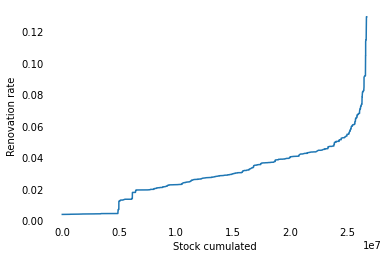

In [70]:
relation = pd.concat((stock_ini_seg, renovation_rate), axis=1)
relation.columns = ['Stock', 'Renovation rate']
relation.sort_values('Renovation rate', inplace=True)
relation['Stock cumulated'] = relation['Stock'].cumsum()

simple_plot(relation['Stock cumulated'], relation['Renovation rate'], 'Stock cumulated', 'Renovation rate')

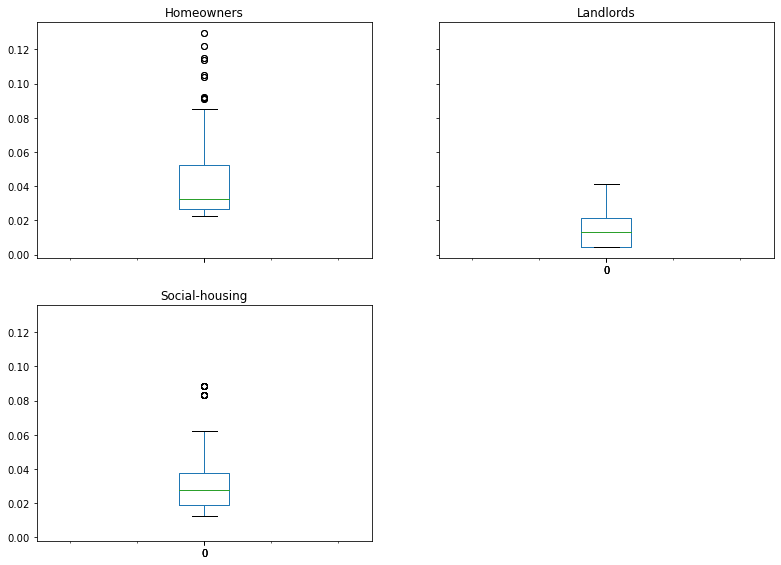

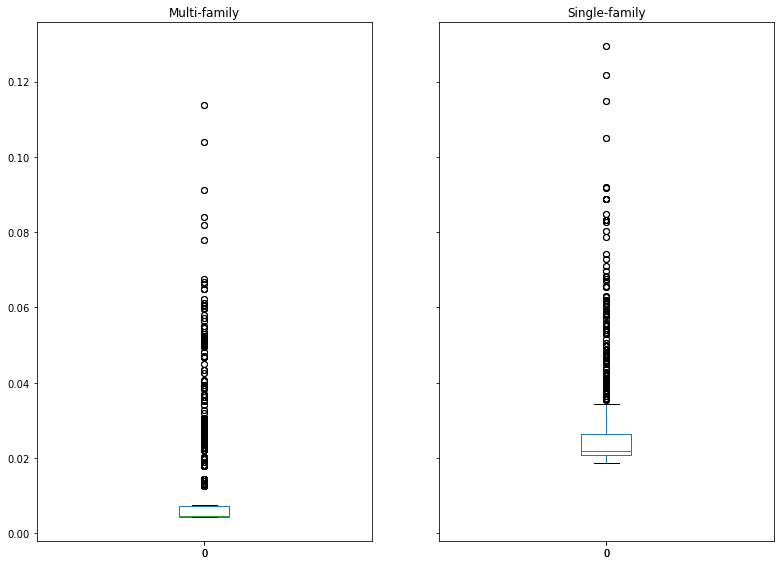

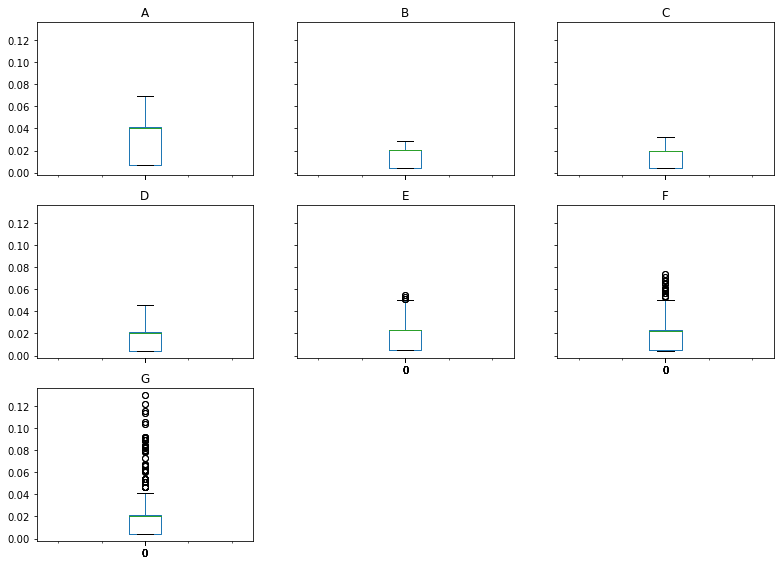

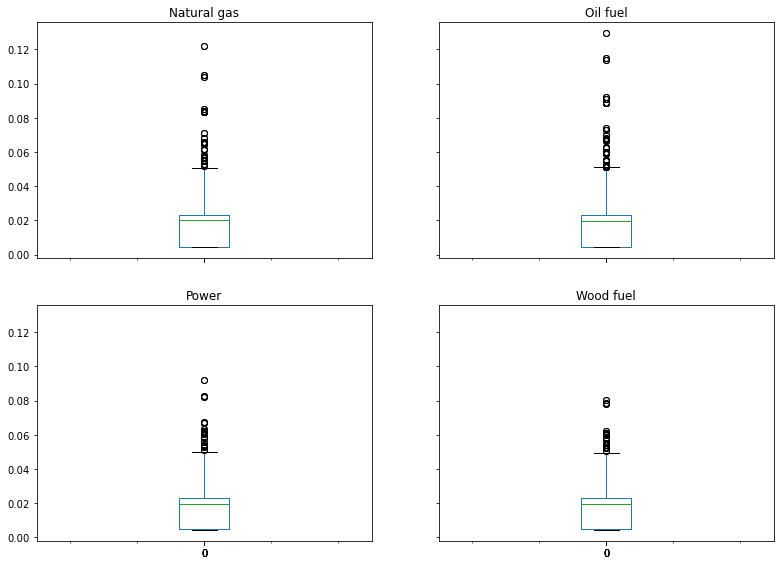

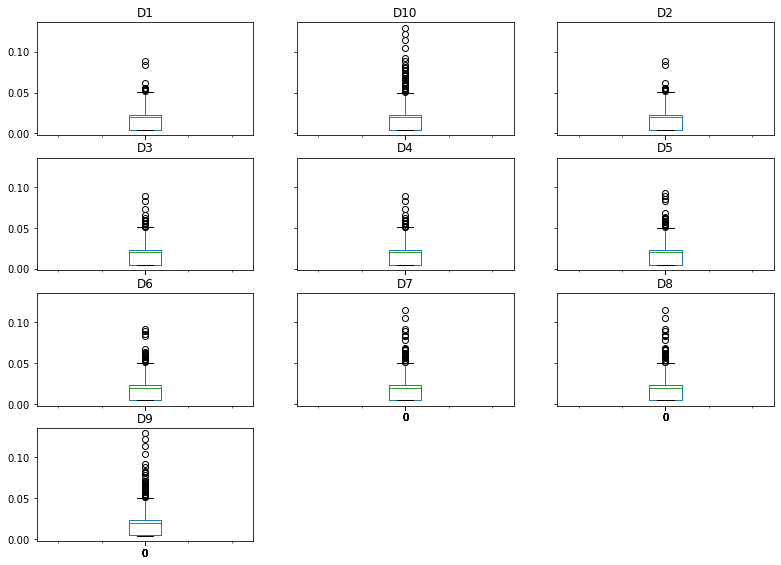

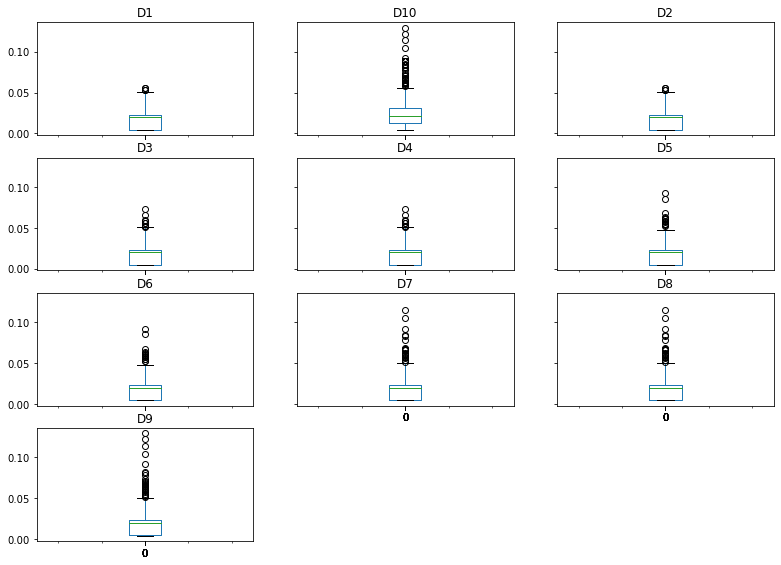

In [71]:
for level in renovation_rate.index.names:
    renovation_rate.to_frame().groupby(level).boxplot(subplots=True, grid=False, sharex=True, figsize=(12.8, 9.6))

## Renovation flow

HousingStockRenovated cla

In [73]:
flow_renovation = renovation_rate * stock_ini_seg
flow_renovation.name = 'Flow renovation'
display(flow_renovation.to_frame().tail().style.format('{:.1f}'))
print('Flow renovation total: {:,.0f} (i.e {:.1%} of total stock)'.format(flow_renovation.sum(), flow_renovation.sum() / stock_ini_seg.sum()))

Flow renovation total: 781,854 (i.e 2.9% of total stock)


### Discrete choice model: Market share

In [74]:
market_share, _ = buildings_dynamic.to_market_share(energy_price, transition=['Energy performance'], consumption='conventional', cost_invest=cost_invest,
                                                 cost_intangible=cost_intangible, policies=None, nu=8.0)

display(market_share.tail().style.format('{:.1%}', na_rep="-"))

### Flow renovation by energy performance final

In [75]:
flow_renovation_ep = (market_share.T * flow_renovation).T
display(flow_renovation_ep.tail().style.format('{:.1f}'))

In [76]:
flow_renovation_ep_grouped = flow_renovation_ep.groupby('Energy performance').sum()
display(flow_renovation_ep_grouped.loc[performance_order, performance_order].style.format('{:,.0f}'))

Energy performance final,G,F,E,D,C,B,A
Energy performance,,,,,,,
G,0,"18,327","19,794","17,654","13,172","1,010",290
F,0,0,"43,459","27,812","27,864","1,827",316
E,0,0,0,"140,071","53,492","10,735",457
D,0,0,0,0,"246,073","12,912",548
C,0,0,0,0,0,"90,484","8,056"
B,0,0,0,0,0,0,"25,025"
A,0,0,0,0,0,0,0


### Flow renovation by energy performance final and heating energy final

#### Market share heating energy final

In [77]:
market_share_he, _ = buildings_dynamic.to_market_share(energy_price,
                                                       transition=['Heating energy'],
                                                       cost_invest=cost_invest,
                                                       consumption='conventional',
                                                       policies=None)

display(market_share_he.tail().style.format('{:.1%}', na_rep="-"))

### Direct functions

Direct functions are implemented in classes to fasten the access to specific output. 

In [78]:
flow_renovation_ep = buildings_dynamic.to_flow_renovation_label(energy_price, consumption='conventional', cost_invest=cost_invest,
                                                                cost_intangible=cost_intangible, policies=None)

display(flow_renovation_ep.tail().style.format('{:.1f}'))

In [79]:
flow_renovation_ep_he = buildings_dynamic.to_flow_renovation_label_energy(energy_price, consumption='conventional', cost_invest=cost_invest,
                                                                          cost_intangible=cost_intangible, policies=None)

display(flow_renovation_ep_he.tail().style.format('{:.1f}'))

## Endougeneous technical change

### Learning by doing

Investment costs decrease exponentially with the cumulative sum of operations so as to capture the classical “learning-by-doing” process.  
The rate of cost reduction is set at 10% in renovation for a doubling of production. 

In [80]:
cost = cost_invest['Energy performance']
display(cost.style.format('{:.0f}'))

learning_rate = dict_parameters['Learning by doing renovation']
print('Learning rate: {:.0%}'.format(learning_rate))

Energy performance final,G,F,E,D,C,B,A
Energy performance,,,,,,,
G,nan,79,142,209,282,365,461
F,nan,nan,66,136,212,299,398
E,nan,nan,nan,73,152,242,345
D,nan,nan,nan,nan,82,176,282
C,nan,nan,nan,nan,nan,97,207
B,nan,nan,nan,nan,nan,nan,115
A,nan,nan,nan,nan,nan,nan,nan


Learning rate: -10%


In [81]:
help(HousingStock.lbd)

Help on function lbd in module project.buildings:

lbd(knowledge, learning_rate)



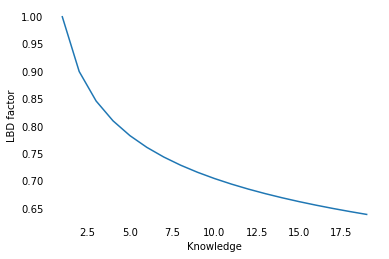

In [82]:
knowledge_range = range(1, 20, 1)
lbd_range = [HousingStock.lbd(knowledge, learning_rate=learning_rate) for knowledge in knowledge_range]

simple_plot(knowledge_range, lbd_range, 'Knowledge', 'LBD factor')

In [83]:
help(HousingStock.learning_by_doing)

Help on function learning_by_doing in module project.buildings:

learning_by_doing(knowledge, cost, learning_rate, cost_lim=None)
    Decrease capital cost after considering learning-by-doing effect.
    
    Investment costs decrease exponentially with the cumulative sum of operations so as to capture
    a “learning-by-doing” process.
    The rate of cost reduction is set at 15% in new construction and 10% in renovation for a doubling of production.
    
    Parameters
    ----------
    knowledge: pd.Series
        knowledge indexes match cost columns to reach final state after transition
    cost: pd.DataFrame
    learning_rate: float
    cost_lim: optional, pd.DataFrame
    
    Returns
    -------
    pd.DataFrame



In [84]:
knowledge = pd.Series(1, index=cost.columns)
cost_learnt = HousingStock.learning_by_doing(knowledge, cost, learning_rate)
cost_learnt = cost_learnt.loc[:, performance_order]
display(cost_learnt.style.format('{:.0f}'))

knowledge = pd.Series(2, index=cost.columns)
cost_learnt = HousingStock.learning_by_doing(knowledge, cost, learning_rate)
cost_learnt = cost_learnt.loc[:, performance_order]
display(cost_learnt.style.format('{:.0f}'))

Energy performance final,G,F,E,D,C,B,A
Energy performance,,,,,,,
G,nan,79,142,209,282,365,461
F,nan,nan,66,136,212,299,398
E,nan,nan,nan,73,152,242,345
D,nan,nan,nan,nan,82,176,282
C,nan,nan,nan,nan,nan,97,207
B,nan,nan,nan,nan,nan,nan,115
A,nan,nan,nan,nan,nan,nan,nan


Energy performance final,G,F,E,D,C,B,A
Energy performance,,,,,,,
G,nan,71,128,188,254,329,415
F,nan,nan,59,122,191,269,358
E,nan,nan,nan,66,137,218,310
D,nan,nan,nan,nan,74,158,254
C,nan,nan,nan,nan,nan,87,187
B,nan,nan,nan,nan,nan,nan,103
A,nan,nan,nan,nan,nan,nan,nan


We observe a 10% reduction of capital cost (based on learnig_rate).

### Information rate

Intangible renovation costs decrease according to a logistic curve with the same cumulative production so as to capture peer effects and knowledge diffusion. The rate of decrease is set at 25% for a doubling of cumulative production.

In [85]:
cost = cost_intangible['Energy performance']
display(cost.tail().style.format('{:.0f}', na_rep="-"))

info_rate_max = dict_parameters['Information rate max renovation']
learning_info_rate = dict_parameters['Learning information rate renovation']

print('Learning info rate: {:.0%}'.format(learning_info_rate))
print('Info rate max: {:.0%}'.format(info_rate_max))

Learning info rate: 25%
Info rate max: 80%


In [86]:
help(HousingStock.information_rate)

Help on function information_rate in module project.buildings:

information_rate(knowledge, learning_rate, info_max)
    Returns information rate.
    
    More info_rate is high, more intangible_cost are low.
    Intangible renovation costs decrease according to a logistic curve with the same cumulative
    production so as to capture peer effects and knowledge diffusion.
    intangible_cost[yr] = intangible_cost[calibrationyear] * info_rate with info rate [1-info_rate_max ; 1]
    This function calibrate a logistic function, so rate of decrease is set at 25% for a doubling of cumulative
    production.
    
    Parameters
    ----------
    knowledge: pd.Series
        knowledge indexes match cost columns to reach final state after transition
    info_max: float
    learning_rate:
    
    Returns
    -------
    float



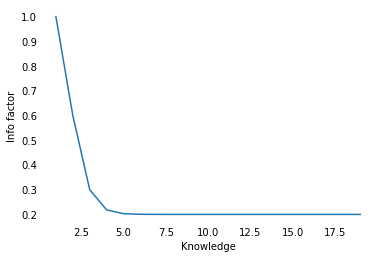

In [87]:
knowledge_range = range(1, 20, 1)
info_range = [HousingStock.information_rate(knowledge, learning_info_rate, info_rate_max) for knowledge in knowledge_range]

simple_plot(knowledge_range, info_range, 'Knowledge', 'Info factor')

In [88]:
help(HousingStock.learning_by_doing)

Help on function learning_by_doing in module project.buildings:

learning_by_doing(knowledge, cost, learning_rate, cost_lim=None)
    Decrease capital cost after considering learning-by-doing effect.
    
    Investment costs decrease exponentially with the cumulative sum of operations so as to capture
    a “learning-by-doing” process.
    The rate of cost reduction is set at 15% in new construction and 10% in renovation for a doubling of production.
    
    Parameters
    ----------
    knowledge: pd.Series
        knowledge indexes match cost columns to reach final state after transition
    cost: pd.DataFrame
    learning_rate: float
    cost_lim: optional, pd.DataFrame
    
    Returns
    -------
    pd.DataFrame



In [89]:
knowledge = pd.Series(1, index=cost.columns)
cost_learnt = HousingStock.acceleration_information(knowledge, cost, info_rate_max, learning_info_rate)
cost_learnt = cost_learnt
display(cost_learnt.groupby('Energy performance').mean().style.format('{:.0f}', na_rep="-"))

knowledge = pd.Series(2, index=cost.columns)
cost_learnt = HousingStock.acceleration_information(knowledge, cost, info_rate_max, learning_info_rate)
cost_learnt = cost_learnt
display(cost_learnt.groupby('Energy performance').mean().style.format('{:.0f}', na_rep="-"))


Energy performance final,A,B,C,D,E,F
Energy performance,,,,,,
C,1,29,-,-,-,-
D,69,8,19,-,-,-
E,83,6,7,25,-,-
F,117,41,11,21,38,-
G,145,130,24,28,37,48


Energy performance final,A,B,C,D,E,F
Energy performance,,,,,,
C,1,18,-,-,-,-
D,41,5,11,-,-,-
E,50,4,4,15,-,-
F,70,24,7,12,23,-
G,87,78,14,17,22,29
